# Load results in dataframe

In [20]:
import pandas as pd

def add_loss_columns(csv_path, model_name_column='model_name'):
    """
    Loads a CSV file, reads the model names, and creates binary columns for included loss functions.
    
    Args:
        csv_path (str): Path to the CSV file.
        model_name_column (str): Name of the column containing the model name.
        
    Returns:
        pd.DataFrame: The extended DataFrame with binary columns for loss functions.
    """
    # Definable list of known loss components (you can extend this)
    known_losses = ['ITM', 'SimCLR', 'MLM', 'CLIP']

    # Load CSV
    df = pd.read_csv(csv_path)

    # Model names in uppercase for more robust detection
    model_names = df[model_name_column].fillna("").str.upper()

    # Add binary columns
    for loss in known_losses:
        df[loss] = model_names.str.contains(loss.upper()).astype(int)

    return df


In [24]:
zeroshot_fpath = "../../test_results/model_scores_zero-shot.csv"
probe_fpath = "../../test_results/model_scores_linear_probe.csv"
retrieval_fpath = "../../test_results/model_scores_retrieval.csv"

In [25]:
df_zeroshot = add_loss_columns(zeroshot_fpath, model_name_column="model_name")
df_probe = add_loss_columns(probe_fpath, model_name_column="model_name")
df_retrieval = add_loss_columns(retrieval_fpath, model_name_column="model")

In [28]:
import pandas as pd
import re

def combine_and_filter_dfs(
    df_zeroshot, 
    df_linear, 
    df_retrieval, 
    target_fraction=1.0, 
    strict_retrieval_filter=True,
    clip_only=False  # <--- NEW
):
    """
    Unifies three model evaluation DataFrames (zeroshot, linear, retrieval) and filters them by dataset_fraction.
    Optionally: Keep only CLIP models.

    Args:
        df_zeroshot (pd.DataFrame): Zero-shot DataFrame.
        df_linear (pd.DataFrame): Linear Probe DataFrame.
        df_retrieval (pd.DataFrame): Retrieval DataFrame.
        target_fraction (float or str): Desired dataset_fraction value (e.g., 0.1, 0.2, 1.0).
        strict_retrieval_filter (bool): If True, retrieval models without a recognizable fraction are discarded.
        clip_only (bool): If True, only models with CLIP=1 are kept.

    Returns:
        pd.DataFrame: Unified and filtered DataFrame.
    """

    # --- Zero-shot ---
    df_zeroshot_filtered = df_zeroshot[df_zeroshot["dataset_fraction"] == target_fraction]
    if clip_only:
        df_zeroshot_filtered = df_zeroshot_filtered[df_zeroshot_filtered["CLIP"] == 1]
    df_zeroshot_std = df_zeroshot_filtered.assign(task="zeroshot")
    df_zeroshot_std = df_zeroshot_std[["score", "metric", "task", "dataset", "CLIP", "ITM", "SimCLR", "MLM"]]

    # --- Linear Probe ---
    df_linear_filtered = df_linear[df_linear["dataset_fraction"] == target_fraction]
    if clip_only:
        df_linear_filtered = df_linear_filtered[df_linear_filtered["CLIP"] == 1]
    df_linear_std = df_linear_filtered.assign(task="linear")
    df_linear_std = df_linear_std[["score", "metric", "task", "dataset", "CLIP", "ITM", "SimCLR", "MLM"]]

    # --- Retrieval ---
    def extract_fraction(model_name):
        model_name = str(model_name)
        if "_" in model_name:
            return model_name.split("_")[-1]

    df_retrieval = df_retrieval.copy()
    df_retrieval["dataset_fraction"] = df_retrieval["model"].apply(extract_fraction)

    if strict_retrieval_filter:
        df_retrieval = df_retrieval[df_retrieval["dataset_fraction"].notna()]
    df_retrieval = df_retrieval[df_retrieval["dataset_fraction"] == target_fraction]
    if clip_only:
        df_retrieval = df_retrieval[df_retrieval["CLIP"] == 1]

    df_retrieval_std = pd.melt(
        df_retrieval,
        id_vars=["dataset", "task", "CLIP", "ITM", "SimCLR", "MLM"],
        value_vars=[
            "text_retrieval_recall@1", "text_retrieval_recall@5", "text_retrieval_recall@10",
            "image_retrieval_recall@1", "image_retrieval_recall@5", "image_retrieval_recall@10",
        ],
        var_name="metric",
        value_name="score"
    )

    # --- Combine ---
    df_all = pd.concat([df_zeroshot_std, df_linear_std, df_retrieval_std], ignore_index=True)

    return df_all

In [29]:
df_all = combine_and_filter_dfs(
    df_zeroshot,
    df_probe,
    df_retrieval,
    target_fraction="1-aug",  # oder 1.0, 0.2, etc.
    clip_only=False
)

# Mixed LM for one task

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import itertools

def fit_lmm_for_task(
    df, 
    task_name, 
    metric_name=None, 
    dataset_fraction=None,
    method_notes=None, 
    score_column="score",
    dataset_column="dataset",
    max_interaction_order=2,
    clip_only=False  # <--- NEW
):
    """
    Fit a Linear Mixed Model for a task, with option: Only consider models with CLIP=1.

    Args:
        df (pd.DataFrame): DataFrame for all tasks or the task-specific one.
        task_name (str): Task name (e.g., "zeroshot", "linear", "zeroshot_retrieval").
        metric_name (str): Metric name (e.g., "Top1Accuracy", "recall@5").
        dataset_fraction (float or str): Training data fraction (e.g., 1.0, 0.1).
        method_notes (str): Optional notes for the method (e.g., "baseline").
        score_column (str): Target variable (default: "score").
        dataset_column (str): Column for the random effect (default: "dataset").
        max_interaction_order (int): Maximum degree of interactions (1 to 4).
        clip_only (bool): If True, only models with CLIP=1 are considered.

    Returns:
        statsmodels MixedLMResults: Fitted model.
    """

    # Filter by task
    if "method" in df.columns:
        df_task = df[df["method"] == task_name].copy()
    elif "task" in df.columns:
        df_task = df[df["task"] == task_name].copy()
    else:
        raise ValueError("Column 'method' or 'task' missing for task filtering.")

    # Filter by method_notes
    if "method_notes" in df_task.columns and method_notes is not None:
        df_task = df_task[df_task["method_notes"] == method_notes]

    # Filter by metric
    if "metric" in df_task.columns and metric_name is not None:
        df_task = df_task[df_task["metric"] == metric_name]
    else:
        if task_name == "zeroshot_retrieval":
            if score_column not in df_task.columns:
                raise ValueError(f"{score_column} missing in DataFrame.")

    # Filter by dataset_fraction or model name
    if "dataset_fraction" in df_task.columns and dataset_fraction is not None:
        df_task = df_task[df_task["dataset_fraction"] == dataset_fraction]
    elif "model" in df_task.columns and dataset_fraction is not None:
        df_task = df_task[df_task["model"].str.contains(str(dataset_fraction))]
    elif dataset_fraction is not None:
        raise ValueError("Neither 'dataset_fraction' nor 'model' available for filtering.")

    # Replace "@" with "_" in column names for retrieval task
    if task_name == "zeroshot_retrieval":
        df_task = df_task.rename(
            columns={col: col.replace("@", "_") for col in df_task.columns if "_retrieval_recall@" in col}
        )
        score_column = score_column.replace("@", "_")

    if df_task.empty:
        raise ValueError("No data left after filtering – please check your inputs.")

    # Ensure the loss columns are integer-encoded
    losses = ["CLIP", "ITM", "SimCLR", "MLM"]
    for loss in losses:
        if loss in df_task.columns:
            df_task[loss] = df_task[loss].astype(int)

    # Only consider CLIP models if desired ---
    if clip_only:
        df_task = df_task[df_task["CLIP"] == 1]
        losses = ["ITM", "SimCLR", "MLM"]  # CLIP is always 1, so not in formula anymore

    # Limit maximum interaction order to 1-4
    if max_interaction_order < 1 or max_interaction_order > 4:
        raise ValueError("max_interaction_order must be between 1 and 4.")

    # Build formula dynamically
    terms = []
    for r in range(1, max_interaction_order + 1):
        combos = itertools.combinations(losses, r)
        for combo in combos:
            terms.append(":".join(combo))
    fixed_effects = " + ".join(terms)
    formula = f"{score_column} ~ {fixed_effects}"

    # Fit Mixed Linear Model
    model = smf.mixedlm(formula, df_task, groups=df_task[dataset_column])
    result = model.fit(method="lbfgs")
    print(formula)

    return result

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_lmm_results(model_result, title="Fixed Effects Estimates", figsize=(12, 8)):
    coef = model_result.fe_params
    conf_int_full = model_result.conf_int()
    pvalues = model_result.pvalues

    fixed_effects = coef.index

    ci_low = []
    ci_high = []
    for param in fixed_effects:
        ci_low.append(conf_int_full.loc[param, 0])
        ci_high.append(conf_int_full.loc[param, 1])
    
    df_plot = pd.DataFrame({
        "effect": fixed_effects,
        "estimate": coef.values,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "pvalue": pvalues[fixed_effects].values
    })

    # Helper function: determine interaction order (number of ':' + 1)
    def interaction_order(effect_name):
        return effect_name.count(":") + 1

    df_plot["order"] = df_plot["effect"].apply(interaction_order)

    # Optional: Shorten/wrap labels for better readability
    def shorten_label(label, max_len=25):
        if len(label) > max_len:
            # Example: wrap at ':'
            parts = label.split(":")
            new_label = ":\n".join(parts)
            return new_label
        else:
            return label
    df_plot["label"] = df_plot["effect"].apply(shorten_label)

    # Sort first by interaction order, then by effect size descending
    df_plot = df_plot.sort_values(by=["order", "estimate"], ascending=[True, False]).reset_index(drop=True)

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Colors by significance (p < 0.05)
    colors = np.where(df_plot["pvalue"] < 0.05, "crimson", "gray")

    # Draw points
    plt.scatter(df_plot["estimate"], df_plot.index, color=colors, s=100, zorder=3)

    # Draw confidence intervals
    for i, row in df_plot.iterrows():
        plt.plot([row["ci_low"], row["ci_high"]], [i, i], color=colors[i], lw=3, zorder=2)

    # Vertical line at 0
    plt.axvline(0, color="black", linestyle="--", lw=1)

    # Y-axis labels
    plt.yticks(df_plot.index, df_plot["label"])

    # Axis label and title
    plt.xlabel("Effect size (estimate)")
    plt.title(title)

    # Legend for colors
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='crimson', label='p < 0.05')
    gray_patch = mpatches.Patch(color='gray', label='p ≥ 0.05')
    plt.legend(handles=[red_patch, gray_patch], loc='lower right')

    plt.tight_layout()
    plt.show()


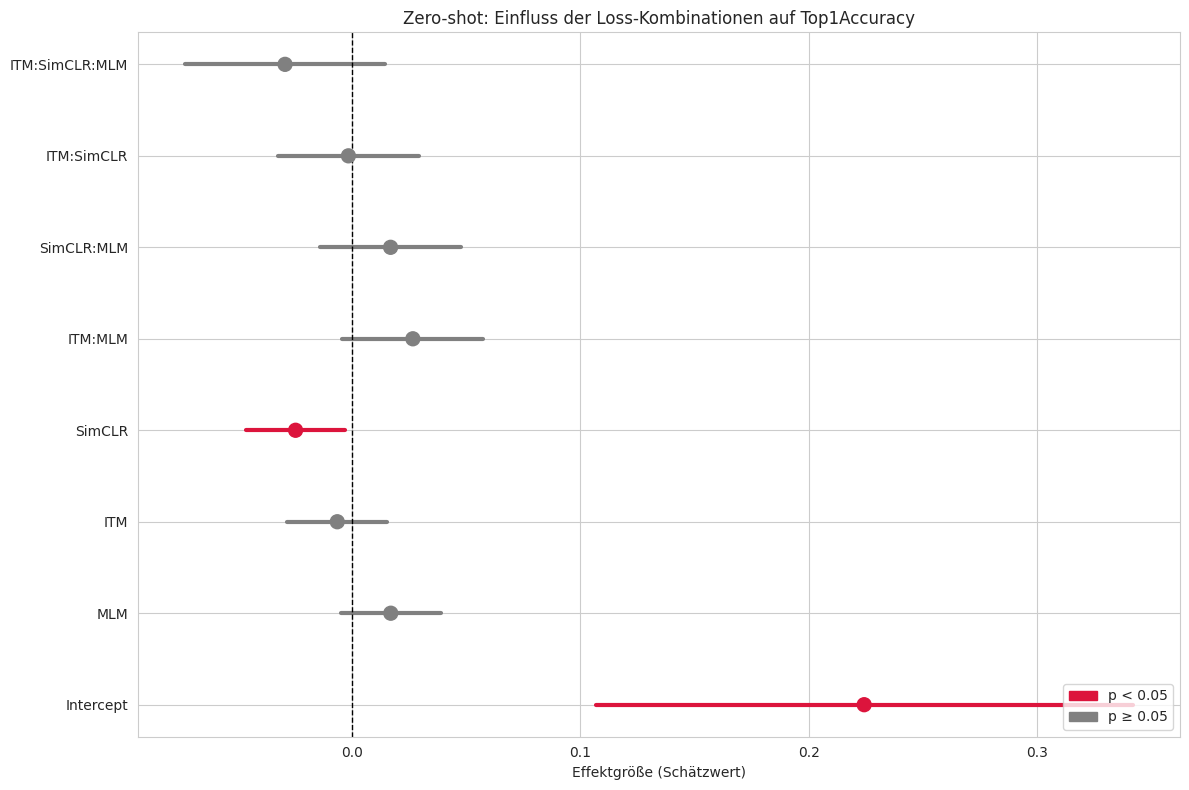

In [ ]:
model = fit_lmm_for_task(
    df=df_zeroshot,
    task_name="zeroshot",
    method_notes="1_templates",
    metric_name="Top1Accuracy",
    dataset_fraction="1-aug",
    score_column="score",
    dataset_column="dataset",
    max_interaction_order=3,
    clip_only=True
)

plot_lmm_results(model, title="Zero-shot: Influence of loss combinations on Top1Accuracy")

In [8]:
model.fe_params

Intercept      0.000281
CLIP           0.219126
ITM            0.012081
SimCLR         0.027265
MLM           -0.003853
CLIP:ITM      -0.008608
CLIP:SimCLR   -0.044591
CLIP:MLM       0.030756
ITM:SimCLR    -0.016120
ITM:MLM        0.007015
SimCLR:MLM     0.002341
dtype: float64

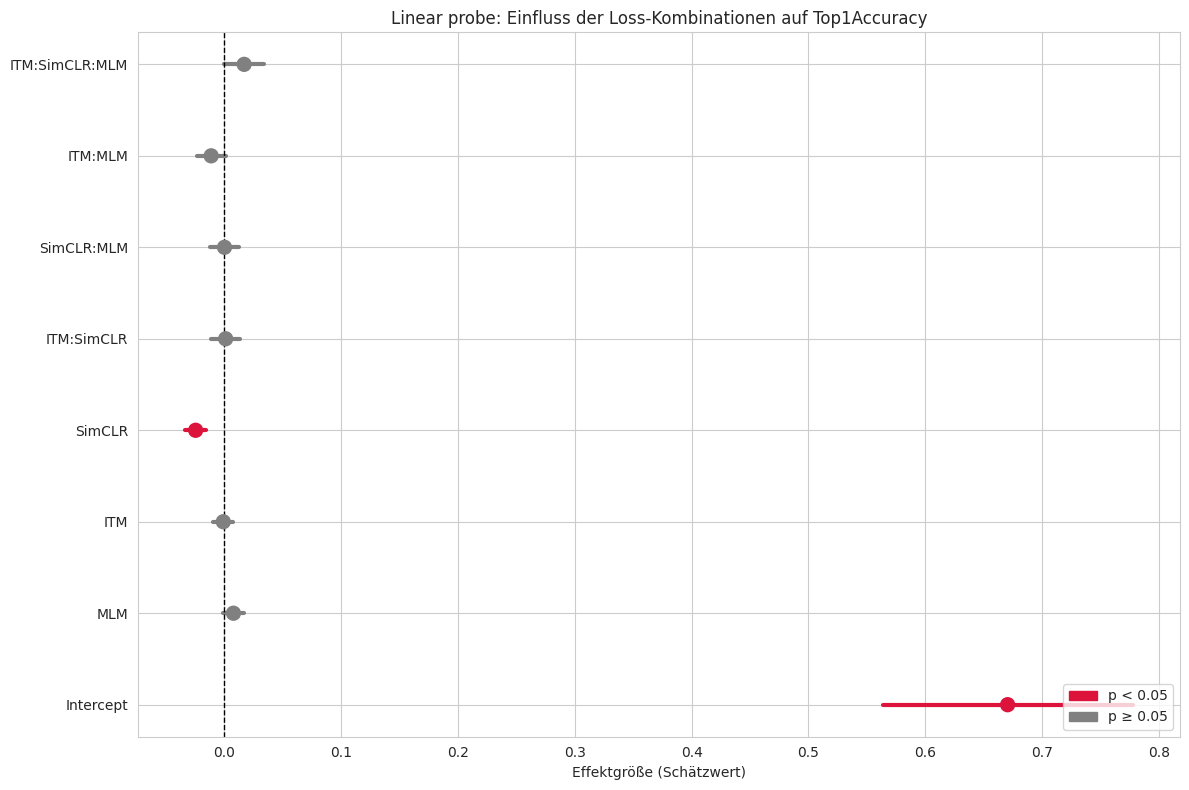

In [ ]:
model = fit_lmm_for_task(
    df=df_probe,
    task_name="linear",
    method_notes="last_image_layer",
    metric_name="Top1Accuracy",
    dataset_fraction="1-aug",
    score_column="score",
    dataset_column="dataset",
    max_interaction_order=3,
    clip_only=True  # Optional: Nur CLIP-Modelle betrachten
)

plot_lmm_results(model, title="Linear probe: Influence of loss combinations on Top1Accuracy")

/home/phisch/venv_py3.8/py3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


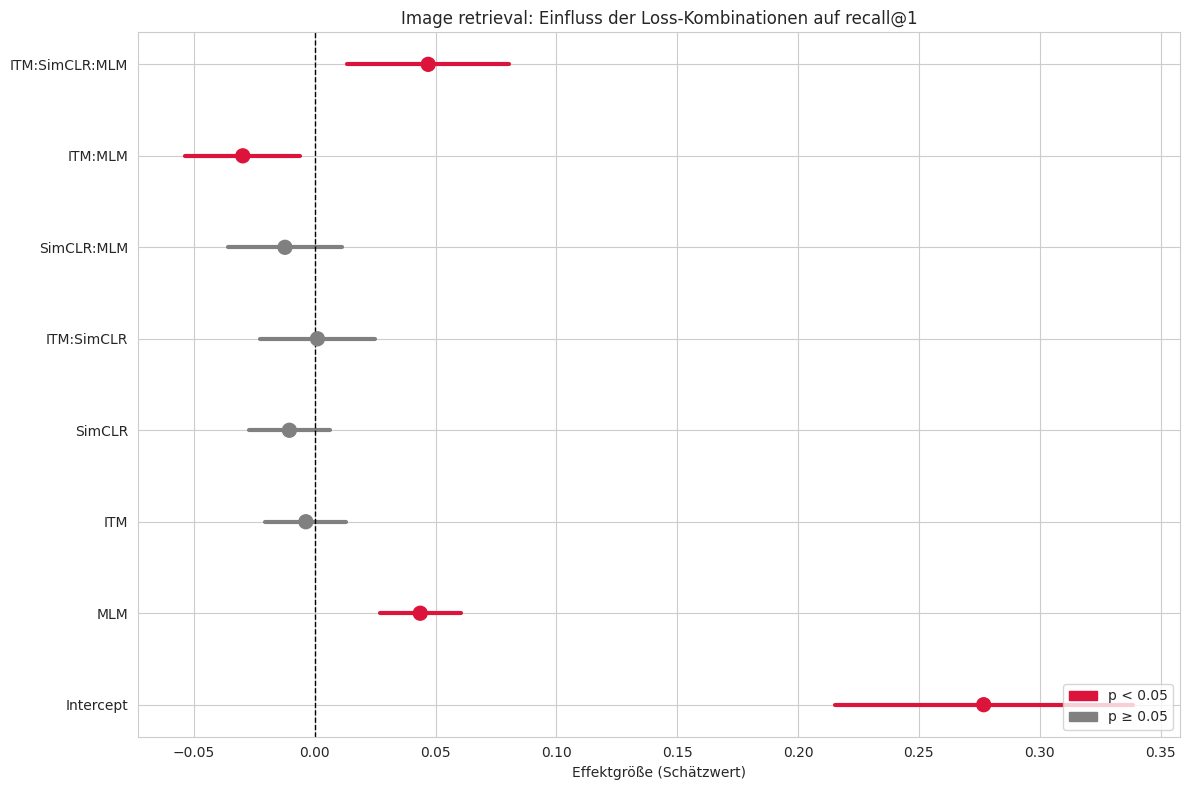

In [ ]:
model = fit_lmm_for_task(
    df=df_retrieval,
    task_name="zeroshot_retrieval",
    dataset_fraction="1-aug",
    score_column="image_retrieval_recall@1",
    dataset_column="dataset",
    max_interaction_order=3,
    clip_only=True
)

plot_lmm_results(model, title="Image retrieval: Influence of loss combinations on recall@1")

/home/phisch/venv_py3.8/py3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


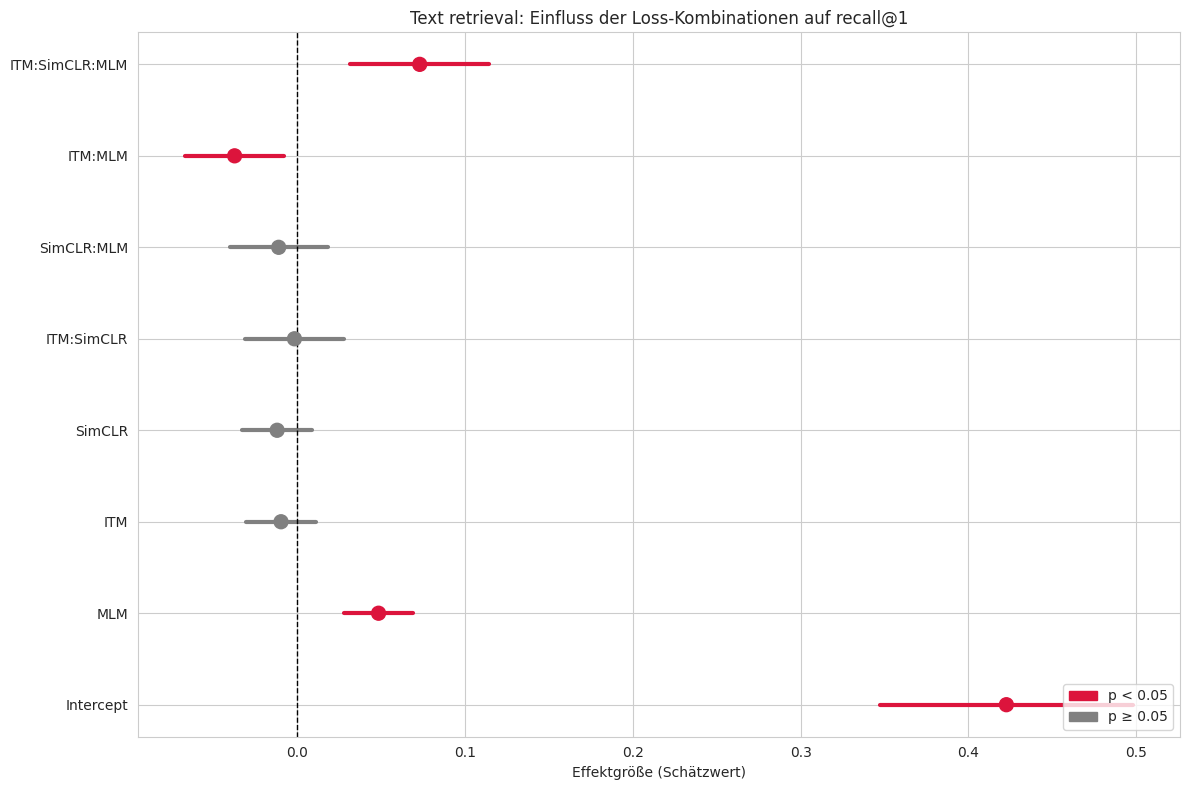

In [ ]:
model = fit_lmm_for_task(
    df=df_retrieval,
    task_name="zeroshot_retrieval",
    dataset_fraction="1-aug",
    score_column="text_retrieval_recall@1",
    dataset_column="dataset",
    max_interaction_order=3,
    clip_only=True
)

plot_lmm_results(model, title="Text retrieval: Influence of loss combinations on recall@1")

# Mixed LM for all tasks

In [ ]:
from statsmodels.formula.api import mixedlm

# Optional: Task-dataset combination as additional random group
df_all["task_dataset"] = df_all["task"] + "_" + df_all["dataset"]

model = mixedlm(
    # "score ~ CLIP * ITM * SimCLR * MLM * task",
    # "score ~ CLIP + ITM + SimCLR + MLM + task",
    "score ~ CLIP + ITM + SimCLR + MLM",
    # "score ~ CLIP * task + ITM * task + SimCLR * task + MLM * task",
    # "score ~ ITM * task + SimCLR * task + MLM * task",
    data=df_all,
    groups="task_dataset",  # or task_dataset for more fine-grained modeling
    # groups=df_all["dataset"],  # Use dataset as random effect
    # vc_formula={"task": "0 + C(task)"}
)
result = model.fit(reml=True)
print(result.summary())


           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  score    
No. Observations:   5097     Method:              REML     
No. Groups:         28       Scale:               0.0175   
Min. group size:    39       Log-Likelihood:      2976.7712
Max. group size:    363      Converged:           Yes      
Mean group size:    182.0                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.303    0.054  5.587 0.000  0.197  0.409
CLIP              0.262    0.004 65.935 0.000  0.254  0.269
ITM               0.002    0.004  0.432 0.666 -0.006  0.010
SimCLR           -0.007    0.004 -1.712 0.087 -0.015  0.001
MLM               0.026    0.004  6.933 0.000  0.019  0.034
task_dataset Var  0.081    0.168                           



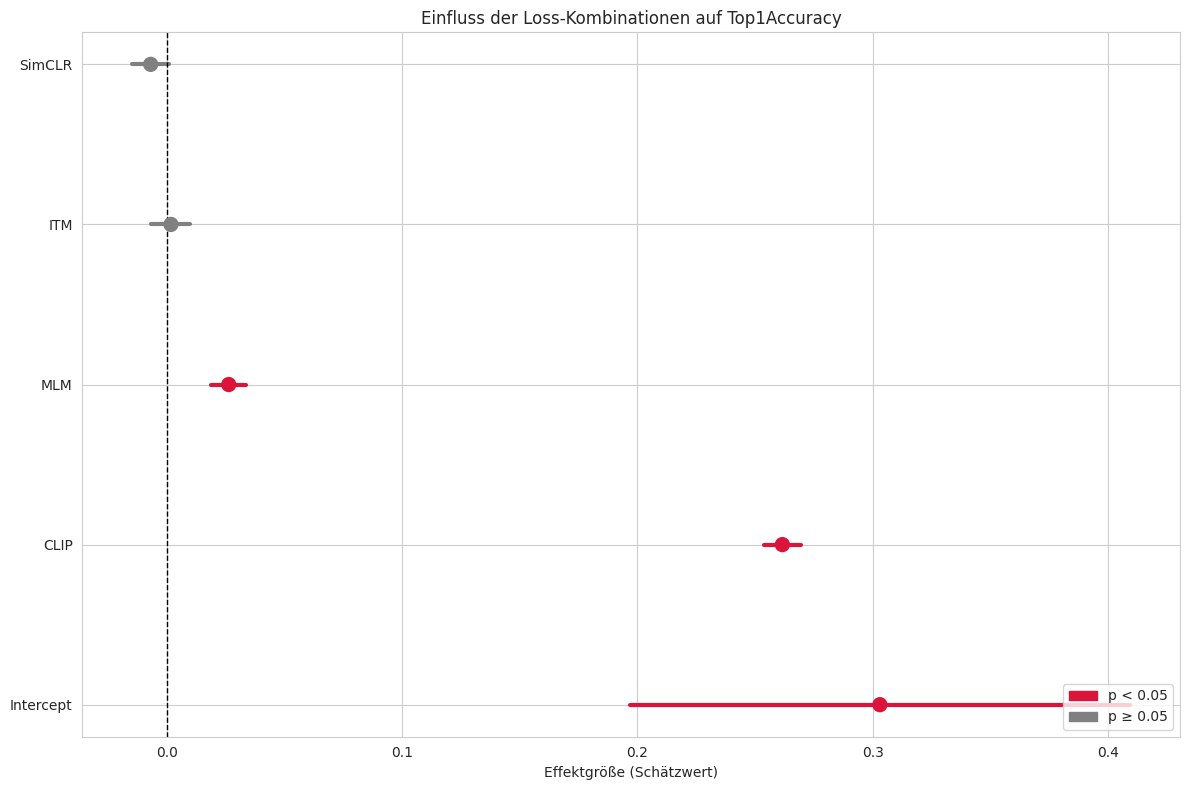

In [ ]:
plot_lmm_results(result, title="Influence of loss combinations on Top1Accuracy")

In [13]:
"""
Mixed Linear Model Regression Results
=============================================================================
Model:                     MixedLM        Dependent Variable:        score   
No. Observations:          1209           Method:                    REML    
No. Groups:                17             Scale:                     0.0178  
Min. group size:           39             Log-Likelihood:            641.4873
Max. group size:           78             Converged:                 Yes     
Mean group size:           71.1                                              
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          0.546    0.046  11.939 0.000  0.457  0.636
task[T.zeroshot]                  -0.475    0.027 -17.796 0.000 -0.527 -0.422
task[T.zeroshot_retrieval]        -0.555    0.105  -5.284 0.000 -0.760 -0.349
CLIP                               0.213    0.013  16.400 0.000  0.187  0.238
CLIP:task[T.zeroshot]              0.049    0.019   2.600 0.009  0.012  0.085
CLIP:task[T.zeroshot_retrieval]    0.367    0.023  15.887 0.000  0.322  0.412
ITM                               -0.007    0.012  -0.553 0.580 -0.030  0.017
ITM:task[T.zeroshot]               0.001    0.017   0.082 0.934 -0.033  0.036
ITM:task[T.zeroshot_retrieval]    -0.000    0.021  -0.021 0.984 -0.042  0.042
SimCLR                             0.029    0.013   2.228 0.026  0.003  0.054
SimCLR:task[T.zeroshot]           -0.036    0.019  -1.945 0.052 -0.073  0.000
SimCLR:task[T.zeroshot_retrieval] -0.027    0.023  -1.171 0.242 -0.072  0.018
MLM                                0.011    0.012   0.875 0.382 -0.013  0.034
MLM:task[T.zeroshot]               0.006    0.017   0.343 0.732 -0.028  0.040
MLM:task[T.zeroshot_retrieval]     0.013    0.021   0.616 0.538 -0.029  0.055
Group Var                          0.025    0.068                            
=============================================================================
"""

'\nMixed Linear Model Regression Results\n=============================================================================\nModel:                     MixedLM        Dependent Variable:        score   \nNo. Observations:          1209           Method:                    REML    \nNo. Groups:                17             Scale:                     0.0178  \nMin. group size:           39             Log-Likelihood:            641.4873\nMax. group size:           78             Converged:                 Yes     \nMean group size:           71.1                                              \n-----------------------------------------------------------------------------\n                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]\n-----------------------------------------------------------------------------\nIntercept                          0.546    0.046  11.939 0.000  0.457  0.636\ntask[T.zeroshot]                  -0.475    0.027 -17.796 0.000 -0.527 -0.422\ntask[T.zer

Danke fürs Teilen der Output-Tabelle! Hier ist eine strukturierte Interpretation deiner Mixed Linear Model Ergebnisse:

---

 🔍 **Allgemeines zum Modell**

* **Fixed Effects:** du untersuchst den Einfluss der vier Losses (`CLIP`, `ITM`, `SimCLR`, `MLM`) auf den Score, jeweils in Abhängigkeit vom Task (`linear_probe`, `zeroshot`, `zeroshot_retrieval`).
* **Random Effect:** `dataset`, um unterschiedliche Schwierigkeitsgrade der Datensätze zu berücksichtigen.

---

 📊 **Interpretation der wichtigsten Ergebnisse**

 1. **Intercept (Baseline: linear\_probe, ohne zusätzliche Losses)**

* **Intercept = 0.546**, p < 0.001: Die durchschnittliche Score-Leistung eines Modells **ohne zusätzliche Losses** im **linear probe Task** beträgt etwa **0.546**.

 2. **Effekte des Tasks**

* `task[T.zeroshot] = -0.475`, p < 0.001
  → Zeroshot ist **signifikant schlechter** als linear\_probe um Ø **0.475** Punkte.
* `task[T.zeroshot_retrieval] = -0.555`, p < 0.001
  → Retrieval ist noch schlechter, Ø **0.555** Punkte unter linear\_probe.

 3. **Haupteffekt CLIP**

* `CLIP = 0.213`, p < 0.001
  → Der Einsatz von CLIP führt **unabhängig vom Task** zu einer signifikanten **Verbesserung um Ø 0.213** Punkte.

 4. **CLIP × Task Interaktion**

* `CLIP:task[T.zeroshot] = 0.049`, p = 0.009
  → CLIP wirkt auch im Zeroshot Task **signifikant zusätzlich positiv**, aber schwächer.
* `CLIP:task[T.zeroshot_retrieval] = 0.367`, p < 0.001
  → Im Retrieval-Task bringt CLIP einen **besonders großen zusätzlichen Gewinn**.

**→ Gesamtwirkung von CLIP:**

* **linear\_probe**: +0.213
* **zeroshot**: +0.213 + 0.049 = **0.262**
* **retrieval**: +0.213 + 0.367 = **0.580**

 5. **ITM: Kein signifikanter Effekt**

* Weder Haupteffekt noch Interaktionen mit Task sind signifikant.
  → **ITM scheint keinen Einfluss auf den Score zu haben.**

 6. **SimCLR**

* **Haupteffekt:** +0.029, p = 0.026 → **leicht positiver Effekt** im linear\_probe Task.
* **zeroshot:** Interaktion –0.036, p = 0.052 → **grenzwertig negativ**, evtl. kein echter Effekt.
* **retrieval:** Interaktion nicht signifikant.

**→ Gesamtwirkung SimCLR:**

* **linear\_probe**: +0.029
* **zeroshot**: +0.029 − 0.036 = **–0.007**
* **retrieval**: +0.029 − 0.027 = **+0.002**

Fazit: **SimCLR hilft nur leicht im linear\_probe Task**, ansonsten neutral bis negativ.

 7. **MLM**

* Keine signifikanten Effekte oder Interaktionen.
  → **MLM scheint keinen relevanten Einfluss zu haben.**

---

 📌 **Random Effect: dataset**

* **Group Var = 0.025** → Es gibt **spürbare Unterschiede zwischen Datensätzen**, die das Modell erklärt.

---

 🧠 **Fazit für deine Fragestellung**

* **CLIP** ist **mit Abstand der stärkste Prädiktor** für gute Scores – **besonders im Retrieval Task**.
* **ITM und MLM haben keinen erkennbaren Einfluss** auf die Leistung.
* **SimCLR** hilft **minimal im linear\_probe**, aber **nicht im zeroshot oder retrieval**.
* Die Tasks unterscheiden sich deutlich im Schwierigkeitsgrad, was dein Modell gut berücksichtigt.

---

Wenn du möchtest, kann ich dir daraus auch ein paar schöne Visualisierungen (z. B. marginale Effekte oder geschätzte Scores pro Kombination) oder einen knappen Ergebnistext für deine Arbeit ableiten. Sag einfach Bescheid!
